### Importing Libraries

In [1]:
from sklearn.datasets import fetch_20newsgroups

import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from sklearn import utils
import multiprocessing
import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.pipeline import Pipeline

In [2]:
categories = ['alt.atheism','talk.religion.misc'] #0, 1
newsgroups_train = fetch_20newsgroups(
    subset='train', remove=('headers', 'footers', 'quotes'), categories=categories)
newsgroups_test = fetch_20newsgroups(
    subset='test', remove=('headers', 'footers', 'quotes'), categories=categories)

In [3]:
train_data=pd.DataFrame({'Article': newsgroups_train['data'], 'Category':newsgroups_train['target']})
train_data.index+=1
#using only training subset for both train and test

#test_data=pd.DataFrame({'Article': newsgroups_test['data'], 'Category':newsgroups_test['target']})
#test_data.index+=1

In [4]:
train_data.shape

(857, 2)

In [5]:
train_data.head()

,Article,Category
1,"Benedikt Rosenau writes, with great authority:...",0
2,\n[...stuff deleted...]\n\nComputers are an ex...,0
3,\n[deletia]\n\n\n In the deletions somewh...,0
4,...\n\n\tBefore or after his kids were shot?\n...,1
5,\n,1


### EDA

In [6]:
train_data['Article']

1      Benedikt Rosenau writes, with great authority:...
2      \n[...stuff deleted...]\n\nComputers are an ex...
3      \n[deletia]\n\n\n      In the deletions somewh...
4      ...\n\n\tBefore or after his kids were shot?\n...
5                                                     \n
                             ...                        
853    \nWell, that explains some things; I posted on...
854    The traditions of the church hold that all the...
855    \nSo what you're saying is that your mind is m...
856    \nTDB> 12. Disease introduced to Brazilian * o...
857    My point is that you set up your views as the ...
Name: Article, Length: 857, dtype: object

In [7]:
train_data['Category'].unique()

array([0, 1], dtype=int64)

In [8]:
train_data.dtypes

Article     object
Category     int64
dtype: object

In [9]:
train_data.isnull().any()

Article     False
Category    False
dtype: bool

<AxesSubplot:xlabel='Category', ylabel='count'>

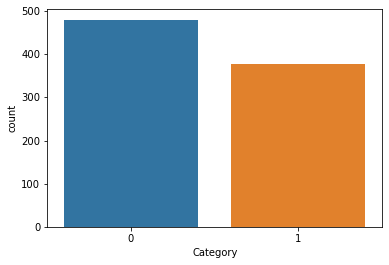

In [10]:
sns.countplot(train_data['Category'])

Text(0.5, 1.0, 'Article length distribution')

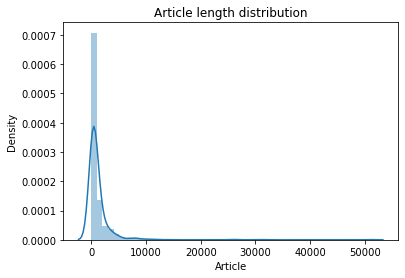

In [11]:
sns.distplot(train_data['Article'].str.len()).set_title('Article length distribution')

In [12]:
def create_wordcloud(words):
    wordcloud=WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)
    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

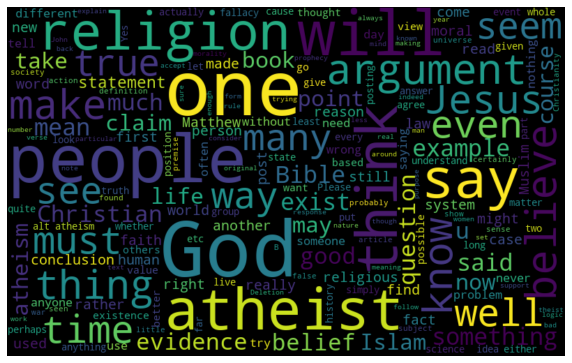

In [13]:
subset=train_data[train_data.Category==0] #atheism
text=subset.Article.values
words=' '.join(text)
create_wordcloud(words)

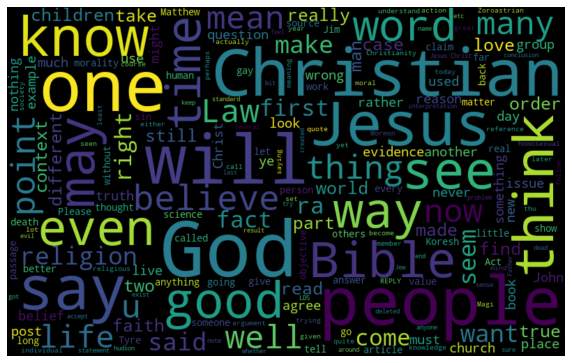

In [14]:
subset=train_data[train_data.Category==1] #religion
text=subset.Article.values
words=' '.join(text)
create_wordcloud(words)

### Text pre-preprocessing

In [15]:
def processing_text(text):
    text=text.lower().replace('\n',' ').replace('\r','').strip()
    text=re.sub(' +',' ', text) #remove more than one space
    text=re.sub(r'[^\w\s]','',text) #remove numeric text
    #text=text.encode("utf-8") #new line--check
    
    stop_words=set(stopwords.words('english'))
    word_tokens=word_tokenize(text)
    filtered_sentence=[word for word in word_tokens if word not in stop_words]
    
    text=' '.join(filtered_sentence)
    return text

In [16]:
train_data['Parsed_article']=train_data['Article'].apply(processing_text)

### Train Test Split

In [17]:
x_train,x_test, y_train, y_test=train_test_split(train_data['Parsed_article'],train_data['Category'], test_size=0.2, random_state=42)

### Feature Extraction

#### 1. WORD2VEC

In [18]:
def w2v(data):
    token_list=[]
    for x in data:
        token_list.append(word_tokenize(x))         
    cores = multiprocessing.cpu_count()
    num_features = 300  
    min_word_count = 3    
    window_size = 6           
    subsampling = 1e-3
    w2v_model = Word2Vec(
                         token_list,
                         workers=cores-1,
                         vector_size=num_features,
                         min_count=min_word_count,
                         window=window_size,
                         sample=subsampling)
    w2v_model.build_vocab([x for x in token_list])
    for epoch in range(30):
        w2v_model.train(utils.shuffle([x for x in token_list]),total_examples=len(token_list), epochs=1)        
    return w2v_model, token_list

def get_w2v_vectors(model, corpus_size, vector_size):
    vectors=np.zeros((corpus_size, vector_size))
    for i in range(0, corpus_size):
        vectors[i] = model.wv[i]
    return vectors

#generating models and obtaining vectors for later predictions

def w2v_training(x_train, x_test):
    xtrain_w2v_model,xtrain_token_list= w2v(x_train)
    xtest_w2v_model,xtest_token_list= w2v(x_test)

    train_vectors_w2v=get_w2v_vectors(xtrain_w2v_model, len(xtrain_token_list), 300)
    test_vectors_w2v=get_w2v_vectors(xtest_w2v_model, len(xtest_token_list), 300)
    
    return train_vectors_w2v, test_vectors_w2v

#### 2. DOC2VEC

In [19]:
def label_sentences(corpus, label_type):
    labeled=[]
    for i,v in enumerate(corpus):
        label=label_type+'_'+str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

def get_vectors(model, corpus_size, vector_size, vector_type):
    vectors=np.zeros((corpus_size, vector_size))
    for i in range(0, corpus_size):
        prefix=vector_type+'_'+str(i)
        vectors[i] = model.dv[prefix]
    return vectors

def d2v_training(x_train, x_test):
    x_train_d2v=label_sentences(x_train,'Train')
    x_test_d2v=label_sentences(x_test,'Test')
    all_data_d2v=x_train_d2v+x_test_d2v
   
    d2v_model=Doc2Vec(dm=0,
                       vector_size=300, #300=3dimfeature vector
                       #negative=5,
                       min_count=1,
                       alpha=0.065,#initial learning rate
                       min_alpha=0.065             
                       )  
    d2v_model.build_vocab([x for x in all_data_d2v]) #creating vocab from entire data
    
    for epoch in range(30):
        d2v_model.train(utils.shuffle([x for x in all_data_d2v]),total_examples=len(all_data_d2v), epochs=1) #shuffling entire data
    
    train_vectors_d2v=get_vectors(d2v_model, len(x_train_d2v), 300, 'Train')
    test_vectors_d2v=get_vectors(d2v_model, len(x_test_d2v),300, 'Test')
    
    return train_vectors_d2v, test_vectors_d2v

#### 3. TFIDF

In [20]:
def tfidf_training(x_train, x_test):
    ngram_range=(3,4)
    min_df=0.001
    max_df=1.
    max_features=250
    tfidf=TfidfVectorizer(encoding='utf-8', 
                          ngram_range= ngram_range, 
                          stop_words=None, 
                          lowercase=False, 
                          max_df=max_df, 
                          min_df=min_df,
                          max_features=max_features,
                          norm='l2',
                          sublinear_tf=True
                         )

    features_train=tfidf.fit_transform(x_train).toarray()
    features_test=tfidf.transform(x_test).toarray() #only transform not fit for test dataset
    
    return features_train, features_test

#### 4. COUNT VECTORIZER

In [21]:
def cv(x_train, x_test):
    count_vectorizer = CountVectorizer()
    x_train_cv= count_vectorizer.fit_transform(x_train).toarray()
    x_test_cv=count_vectorizer.transform(x_test).toarray()
    return x_train_cv, x_test_cv

### Bench marking

In [22]:
feat_tools={"CountVector": cv(x_train, x_test),
            "TF-IDF": tfidf_training(x_train, x_test), 
            "Word2Vec": w2v_training(x_train, x_test), 
            "Doc2Vec": d2v_training(x_train, x_test),
           }
classifiers={'Decision Tree':DecisionTreeClassifier(),
            'Multinomial Naive Bayes':MultinomialNB(), 
            'Logistic Regression': LogisticRegression(),
            'SVM':SVC(),
            'Random Forest':RandomForestClassifier(),
            'Stochastic Gradient Decsent':SGDClassifier()
            }

print('Feature Extractor | Classifier | Accuracy Score ')

results=pd.DataFrame()
for key, value in feat_tools.items():
    for clfname, clf in classifiers.items():
        model=clf
        try:
            model.fit(value[0],y_train)            
        except ValueError:
            model = Pipeline([('Normalizing',MinMaxScaler()),('MultinomialNB',clf)]) #using minmax because multinomial can't handle negative values in the vectors
            model.fit(value[0],y_train)
        predictions=model.predict(value[1])
        print(key," | ", clfname , " | ", accuracy_score(y_test,predictions))
        results = results.append({'Accuracy Score': accuracy_score(y_test,predictions), 
                                'Classifier': clfname,
                                'Feature Extractor': key }, 
                                 ignore_index=True)

Feature Extractor | Classifier | Accuracy Score 
CountVector  |  Decision Tree  |  0.6511627906976745
CountVector  |  Multinomial Naive Bayes  |  0.75
CountVector  |  Logistic Regression  |  0.7209302325581395
CountVector  |  SVM  |  0.6162790697674418
CountVector  |  Random Forest  |  0.6453488372093024
CountVector  |  Stochastic Gradient Decsent  |  0.7151162790697675
TF-IDF  |  Decision Tree  |  0.5581395348837209
TF-IDF  |  Multinomial Naive Bayes  |  0.5581395348837209
TF-IDF  |  Logistic Regression  |  0.5581395348837209
TF-IDF  |  SVM  |  0.5581395348837209
TF-IDF  |  Random Forest  |  0.5581395348837209
TF-IDF  |  Stochastic Gradient Decsent  |  0.5581395348837209
Word2Vec  |  Decision Tree  |  0.5
Word2Vec  |  Multinomial Naive Bayes  |  0.5406976744186046
Word2Vec  |  Logistic Regression  |  0.46511627906976744
Word2Vec  |  SVM  |  0.5406976744186046
Word2Vec  |  Random Forest  |  0.4941860465116279
Word2Vec  |  Stochastic Gradient Decsent  |  0.45348837209302323
Doc2Vec  |  

In [23]:
results.sort_values(by='Accuracy Score', ascending=False)

,Accuracy Score,Classifier,Feature Extractor
1,0.750000,Multinomial Naive Bayes,CountVector
21,0.726744,SVM,Doc2Vec
20,0.726744,Logistic Regression,Doc2Vec
2,0.720930,Logistic Regression,CountVector
5,0.715116,Stochastic Gradient Decsent,CountVector
23,0.680233,Stochastic Gradient Decsent,Doc2Vec
22,0.656977,Random Forest,Doc2Vec
0,0.651163,Decision Tree,CountVector
4,0.645349,Random Forest,CountVector
19,0.616279,Multinomial Naive Bayes,Doc2Vec


In [24]:
results.to_csv('Murk_Task0_Text_Classification.csv')